In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer

import xgboost as xgb

from sklearn.metrics import mean_squared_error,r2_score

from sklearn.model_selection import RandomizedSearchCV


## Load Data

In [11]:
df = pd.read_csv('./data/raw.csv')
df = df[['emp_title','emp_length','state','homeownership','annual_income','verified_income','debt_to_income','annual_income_joint','verification_income_joint','debt_to_income_joint','delinq_2y','months_since_last_delinq','earliest_credit_line','inquiries_last_12m','total_credit_lines','open_credit_lines','total_credit_limit','total_credit_utilized','num_collections_last_12m','num_historical_failed_to_pay','months_since_90d_late','current_accounts_delinq','total_collection_amount_ever','current_installment_accounts','accounts_opened_24m','months_since_last_credit_inquiry','num_satisfactory_accounts','num_accounts_120d_past_due','num_accounts_30d_past_due','num_active_debit_accounts','total_debit_limit','num_total_cc_accounts','num_open_cc_accounts','num_cc_carrying_balance','num_mort_accounts','account_never_delinq_percent','tax_liens','public_record_bankrupt','loan_purpose','application_type','loan_amount','term','interest_rate']]
df.head()

,emp_title,emp_length,state,homeownership,annual_income,verified_income,debt_to_income,annual_income_joint,verification_income_joint,debt_to_income_joint,...,num_cc_carrying_balance,num_mort_accounts,account_never_delinq_percent,tax_liens,public_record_bankrupt,loan_purpose,application_type,loan_amount,term,interest_rate
0,global config engineer,3.0,NJ,MORTGAGE,90000.0,Verified,18.01,NaN,NaN,NaN,...,6,1,92.9,0,0,moving,individual,28000,60,14.07
1,warehouse office clerk,10.0,HI,RENT,40000.0,Not Verified,5.04,NaN,NaN,NaN,...,4,0,100.0,0,1,debt_consolidation,individual,5000,36,12.61
2,assembly,3.0,WI,RENT,40000.0,Source Verified,21.15,NaN,NaN,NaN,...,6,0,93.5,0,0,other,individual,2000,36,17.09
3,customer service,1.0,PA,RENT,30000.0,Not Verified,10.16,NaN,NaN,NaN,...,2,0,100.0,1,0,debt_consolidation,individual,21600,36,6.72
4,security supervisor,10.0,CA,RENT,35000.0,Verified,57.96,57000.0,Verified,37.66,...,13,0,100.0,0,0,credit_card,joint,23000,36,14.07


In [12]:
features = ['emp_title','emp_length','state','homeownership','annual_income','verified_income','debt_to_income','annual_income_joint','verification_income_joint','debt_to_income_joint','delinq_2y','months_since_last_delinq','earliest_credit_line','inquiries_last_12m','total_credit_lines','open_credit_lines','total_credit_limit','total_credit_utilized','num_collections_last_12m','num_historical_failed_to_pay','months_since_90d_late','current_accounts_delinq','total_collection_amount_ever','current_installment_accounts','accounts_opened_24m','months_since_last_credit_inquiry','num_satisfactory_accounts','num_accounts_120d_past_due','num_accounts_30d_past_due','num_active_debit_accounts','total_debit_limit','num_total_cc_accounts','num_open_cc_accounts','num_cc_carrying_balance','num_mort_accounts','account_never_delinq_percent','tax_liens','public_record_bankrupt','loan_purpose','application_type','loan_amount','term']
target = 'interest_rate'

## Data Description

Por hacer

## Data Preparation

In [13]:
categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.strip().str.replace(' ', '_')
    # df[c] = df[c].str.replace(' ', '_')
    # .str.replace(' ', '_')

In [14]:
df.head()
print(df.shape)

(10000, 43)


In [15]:
df.isnull().sum().sort_values(ascending=False)

verification_income_joint           8545
annual_income_joint                 8505
debt_to_income_joint                8505
months_since_90d_late               7715
months_since_last_delinq            5658
months_since_last_credit_inquiry    1271
emp_title                            833
emp_length                           817
num_accounts_120d_past_due           318
debt_to_income                        24
num_open_cc_accounts                   0
num_accounts_30d_past_due              0
num_active_debit_accounts              0
total_debit_limit                      0
num_total_cc_accounts                  0
tax_liens                              0
num_cc_carrying_balance                0
num_mort_accounts                      0
account_never_delinq_percent           0
public_record_bankrupt                 0
loan_purpose                           0
application_type                       0
loan_amount                            0
term                                   0
num_satisfactory

In [16]:
# Delete with too many missing values and no prediction power
del df['verification_income_joint']
del df['annual_income_joint']
del df['debt_to_income_joint']

In [17]:
# Filling missing values with 0
df['months_since_last_delinq'] = df['months_since_last_delinq'].fillna(0)
df['months_since_90d_late'] = df['months_since_90d_late'].fillna(0)
df['months_since_last_credit_inquiry'] = df['months_since_last_credit_inquiry'].fillna(0)
df['num_accounts_120d_past_due'] = df['num_accounts_120d_past_due'].fillna(0)
df['emp_title'] = df['emp_title'].fillna('missing')
df['emp_length'] = df['emp_length'].fillna(0)
df['debt_to_income'] = df['debt_to_income'].fillna(0)


In [18]:
df.head().T

,0,1,2,3,4
emp_title,global_config_engineer,warehouse_office_clerk,assembly,customer_service,security_supervisor
emp_length,3.0,10.0,3.0,1.0,10.0
state,nj,hi,wi,pa,ca
homeownership,mortgage,rent,rent,rent,rent
annual_income,90000.0,40000.0,40000.0,30000.0,35000.0
verified_income,verified,not_verified,source_verified,not_verified,verified
debt_to_income,18.01,5.04,21.15,10.16,57.96
delinq_2y,0,0,0,0,0
months_since_last_delinq,38.0,0.0,28.0,0.0,0.0
earliest_credit_line,2001,1996,2006,2007,2008


In [19]:
# Export data prepared to parquet

# df.to_parquet('./data/processed.parquet',engine='pyarrow')

## EDA

In [20]:
# df.to_csv('./data/processed.csv',index=False)

In [21]:
df = pd.read_parquet('./data/processed.parquet',engine='pyarrow')
df.head().T

,0,1,2,3,4
emp_title,global_config_engineer,warehouse_office_clerk,assembly,customer_service,security_supervisor
emp_length,3.0,10.0,3.0,1.0,10.0
state,nj,hi,wi,pa,ca
homeownership,mortgage,rent,rent,rent,rent
annual_income,90000.0,40000.0,40000.0,30000.0,35000.0
verified_income,verified,not_verified,source_verified,not_verified,verified
debt_to_income,18.01,5.04,21.15,10.16,57.96
delinq_2y,0,0,0,0,0
months_since_last_delinq,38.0,0.0,28.0,0.0,0.0
earliest_credit_line,2001,1996,2006,2007,2008


In [22]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
emp_length,10000.0,5.445800,3.903279,0.00,2.0000,5.00,10.00,10.00
annual_income,10000.0,79222.148412,64734.290492,0.00,45000.0000,65000.00,95000.00,2300000.00
debt_to_income,10000.0,19.261852,15.016585,0.00,10.9975,17.53,24.99,469.09
delinq_2y,10000.0,0.216000,0.683660,0.00,0.0000,0.00,0.00,13.00
months_since_last_delinq,10000.0,15.961500,23.135028,0.00,0.0000,0.00,29.00,118.00
earliest_credit_line,10000.0,2001.290000,7.795510,1963.00,1997.0000,2003.00,2006.00,2015.00
inquiries_last_12m,10000.0,1.958200,2.380130,0.00,0.0000,1.00,3.00,29.00
total_credit_lines,10000.0,22.679600,11.885439,2.00,14.0000,21.00,29.00,87.00
open_credit_lines,10000.0,11.404400,5.868280,0.00,7.0000,10.00,14.00,51.00
total_credit_limit,10000.0,183606.230400,187632.707777,0.00,51593.7500,114667.00,267550.00,3386034.00


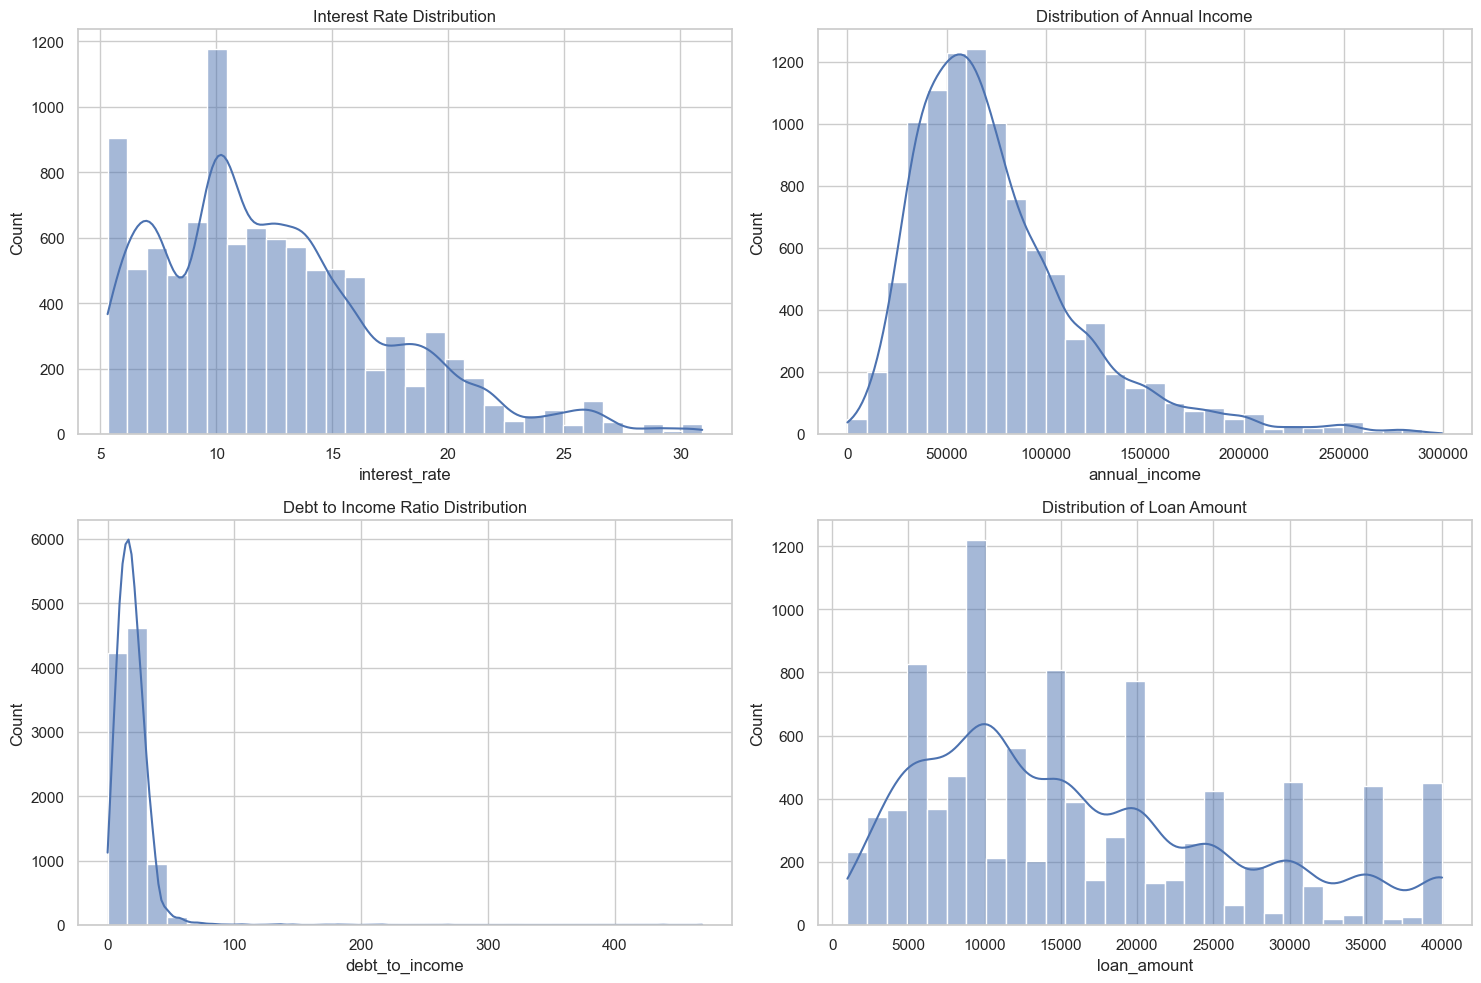

In [23]:
# Configuración de estilo de las visualizaciones
sns.set(style="whitegrid")

# Creando un conjunto de gráficos para variables seleccionadas
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Gráfico para la distribución de la tasa de interés
sns.histplot(df['interest_rate'], bins=30, ax=axes[0, 0], kde=True)
axes[0, 0].set_title('Interest Rate Distribution')

# Gráfico para la distribución del ingreso anual
sns.histplot(df[df['annual_income'] < 300000]['annual_income'], bins=30, ax=axes[0, 1], kde=True)
axes[0, 1].set_title('Distribution of Annual Income')

# Gráfico para la relación entre deuda e ingreso
sns.histplot(df['debt_to_income'], bins=30, ax=axes[1, 0], kde=True)
axes[1, 0].set_title('Debt to Income Ratio Distribution')

# Gráfico para la distribución del monto del préstamo
sns.histplot(df['loan_amount'], bins=30, ax=axes[1, 1], kde=True)
axes[1, 1].set_title('Distribution of Loan Amount')

plt.tight_layout()
plt.show()

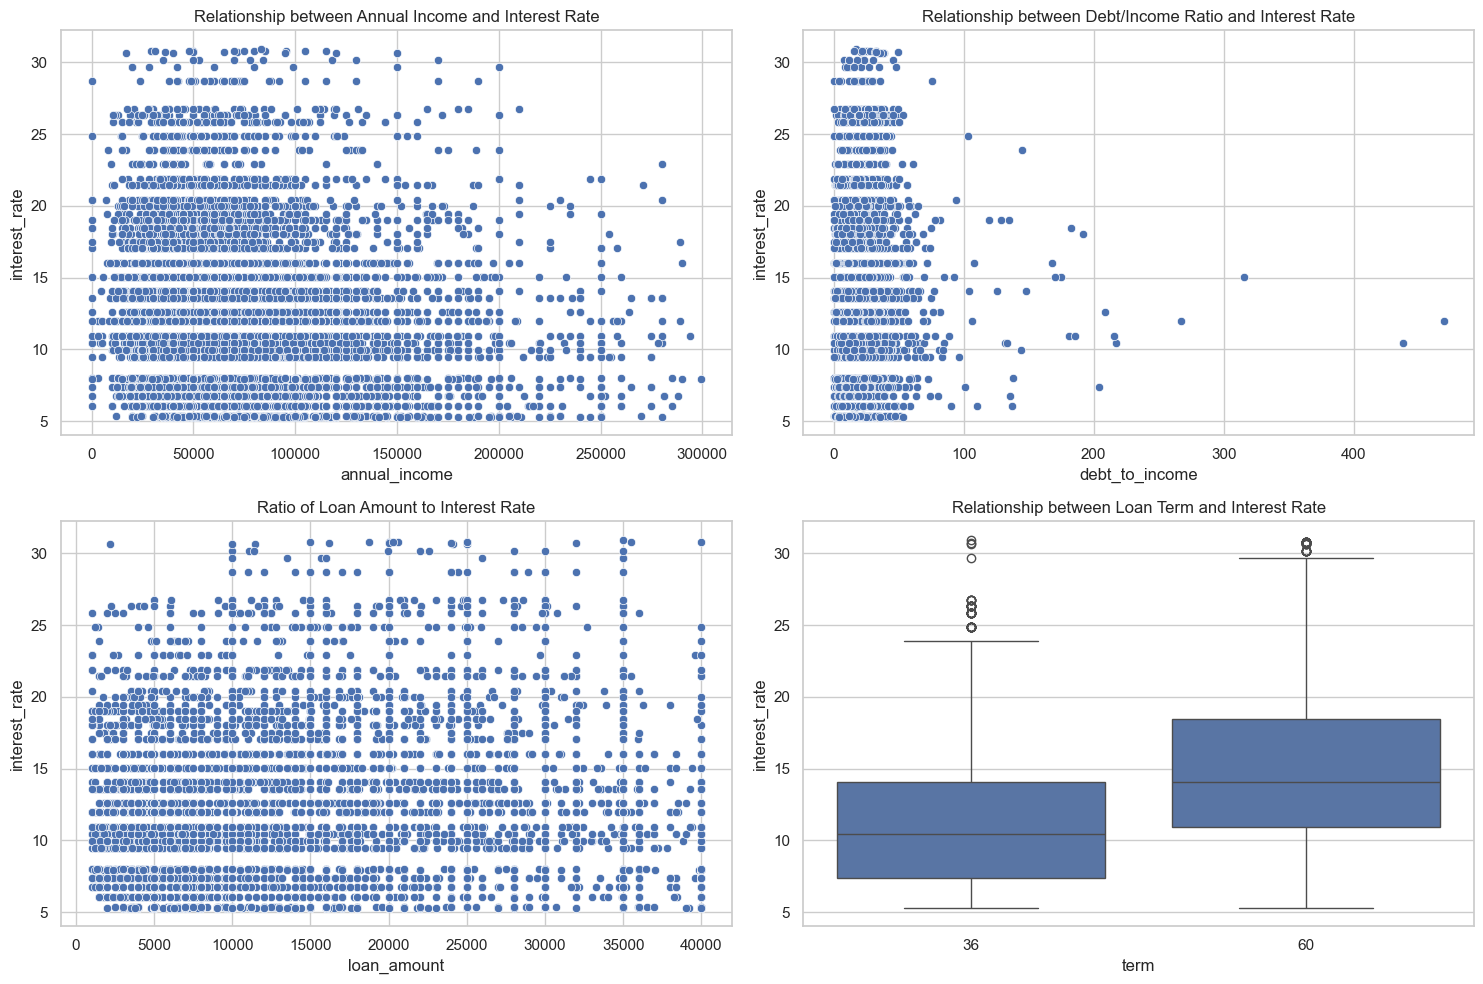

In [24]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
sns.scatterplot(x='annual_income', y='interest_rate', data=df[df['annual_income'] < 300000])
plt.title('Relationship between Annual Income and Interest Rate')

# Relación entre Relación Deuda/Ingreso y Tasa de Interés
plt.subplot(2, 2, 2)
sns.scatterplot(x='debt_to_income', y='interest_rate', data=df)
plt.title('Relationship between Debt/Income Ratio and Interest Rate')

# Relación entre Monto del Préstamo y Tasa de Interés
plt.subplot(2, 2, 3)
sns.scatterplot(x='loan_amount', y='interest_rate', data=df)
plt.title('Ratio of Loan Amount to Interest Rate')

# Relación entre Término del Préstamo y Tasa de Interés
plt.subplot(2, 2, 4)
sns.boxplot(x='term', y='interest_rate', data=df)
plt.title('Relationship between Loan Term and Interest Rate')

plt.tight_layout()
plt.show()


In [25]:
df[df.columns[df.dtypes == 'object']].nunique().sort_values(ascending=False)

emp_title           4412
state                 50
loan_purpose          12
homeownership          3
verified_income        3
application_type       2
dtype: int64

In [26]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

## Data Splitting

In [27]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [28]:
df_full_train = df_full_train.reset_index(drop=True)
y_full_train = df_full_train[target].values
del df_full_train[target]

In [29]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [30]:
y_train = df_train[target].values
y_val = df_val[target].values
y_test = df_test[target].values

del df_train[target]
del df_val[target]
del df_test[target]

In [31]:
len(df_train), len(df_val), len(df_test)

(6000, 2000, 2000)

In [32]:
train_dicts = df_train.to_dict(orient='records')

In [33]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

In [34]:
dv

DictVectorizer(sparse=False)

In [35]:
X_train

array([[1.0000e+02, 7.0000e+00, 8.2000e+04, ..., 1.0000e+00, 0.0000e+00,
        0.0000e+00],
       [1.0000e+02, 3.0000e+00, 2.1200e+05, ..., 0.0000e+00, 1.0000e+00,
        0.0000e+00],
       [8.6700e+01, 1.0000e+00, 2.4576e+04, ..., 0.0000e+00, 0.0000e+00,
        1.0000e+00],
       ...,
       [9.6300e+01, 1.0000e+00, 1.0700e+05, ..., 1.0000e+00, 0.0000e+00,
        0.0000e+00],
       [1.0000e+02, 8.0000e+00, 8.3043e+04, ..., 0.0000e+00, 0.0000e+00,
        1.0000e+00],
       [6.2900e+01, 2.0000e+00, 6.2000e+04, ..., 0.0000e+00, 1.0000e+00,
        0.0000e+00]])

In [36]:
val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)

test_dicts = df_test.to_dict(orient='records')
X_test = dv.transform(test_dicts)

## Model

In [368]:
import xgboost as xgb
# Preparar los datos en formato DMatrix, que es una estructura de datos eficiente para XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test, label=y_test)

# Parámetros para XGBoost (puedes ajustar estos parámetros para mejorar el modelo)
params = {
    'max_depth': 6, 
    'eta': 0.3, 
    'objective': 'reg:squarederror'
}

# Entrenar el modelo
xgb = xgb.train(params, dtrain, num_boost_round=10)

In [369]:
y_pred_val = xgb.predict(dval)
y_pred_train = xgb.predict(dtrain)
y_pred_test = xgb.predict(dtest)

In [370]:
# Realizar predicciones y evaluar el modelo
y_pred_train = xgb.predict(dtrain)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
print(f"RMSE : {rmse_train}")
# print(f"R2 con características filtradas: {r2_score(y_train, y_pred_train)}")

RMSE : 3.2449262965349988


In [371]:
# Realizar predicciones y evaluar el modelo
y_pred_test = xgb.predict(dtest)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
print(f"RMSE con características filtradas: {rmse_test}")
# print(f"R2 con características filtradas: {r2_score(y_test, y_pred_test)}")

RMSE con características filtradas: 3.939461668634974


In [372]:
# Realizar predicciones y evaluar el modelo
y_pred_val = xgb.predict(dval)
rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val))
print(f"RMSE con características filtradas: {rmse_val}")
# print(f"R2 con características filtradas: {r2_score(y_test, y_pred_test)}")

RMSE con características filtradas: 4.025626466578873


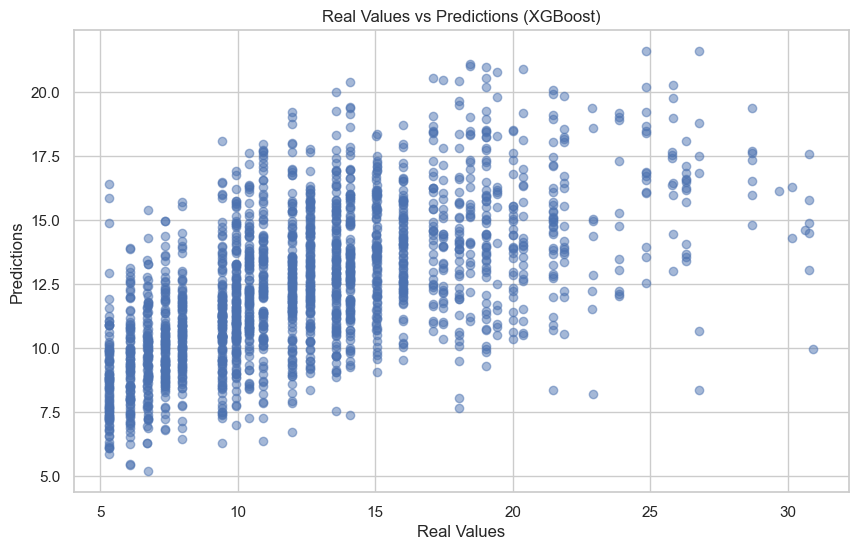

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_pred_val, alpha=0.5)
plt.xlabel('Real Values')
plt.ylabel('Predictions')
plt.title('Real Values vs Predictions (XGBoost)')
plt.show()

## Model Tunning

In [373]:
import xgboost as xgb
# Define the range of hyperparameters for the search

# Parámetros iniciales para XGBoost
params = {
    'objective': 'reg:squarederror'  # Definido explícitamente para problemas de regresión
}

# Definir los rangos de hiperparámetros para la búsqueda
gridsearch_params = [
    (max_depth, eta)
    for max_depth in range(3, 10)
    for eta in [0.01, 0.05, 0.1, 0.3]
]

# Configuración inicial de parámetros
min_rmse = float("Inf")
best_params = None

# Búsqueda de hiperparámetros
for max_depth, eta in gridsearch_params:
    print(f"CV with max_depth={max_depth}, eta={eta}")
    
    # Actualizar los parámetros
    params['max_depth'] = max_depth
    params['eta'] = eta

    # Validación cruzada
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=10,
        seed=42,
        nfold=3,  # Número de pliegues en CV
        metrics={'rmse'},
        early_stopping_rounds=10
    )

    # Actualizar el mejor RMSE
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].idxmin()
    print(f"\tRMSE {mean_rmse} for {boost_rounds} rounds")
    
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = (max_depth, eta)

print(f"Best parameters: max_depth={best_params[0]}, eta={best_params[1]}, RMSE: {min_rmse}")

# Entrenar y evaluar el modelo con los mejores parámetros
params['max_depth'] = best_params[0]
params['eta'] = best_params[1]

best_model = xgb.train(
    params,
    dtrain,
    num_boost_round=boost_rounds
)

# Evaluar el modelo
y_pred = best_model.predict(dtest)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE on the test set: {rmse}")

# Evaluar el modelo
y_pred = best_model.predict(dval)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
print(f"RMSE on the validation set: {rmse}")

CV with max_depth=3, eta=0.01
	RMSE 4.8977204625809465 for 9 rounds
CV with max_depth=3, eta=0.05
	RMSE 4.5919111939231465 for 9 rounds
CV with max_depth=3, eta=0.1
	RMSE 4.386697408163169 for 9 rounds
CV with max_depth=3, eta=0.3
	RMSE 4.085501564616737 for 9 rounds
CV with max_depth=4, eta=0.01
	RMSE 4.885369993143965 for 9 rounds
CV with max_depth=4, eta=0.05
	RMSE 4.541037321429083 for 9 rounds
CV with max_depth=4, eta=0.1
	RMSE 4.314135691790034 for 9 rounds
CV with max_depth=4, eta=0.3
	RMSE 4.043549296634713 for 9 rounds
CV with max_depth=5, eta=0.01
	RMSE 4.874548306387898 for 9 rounds
CV with max_depth=5, eta=0.05
	RMSE 4.49857886471574 for 9 rounds
CV with max_depth=5, eta=0.1
	RMSE 4.252426448275806 for 9 rounds
CV with max_depth=5, eta=0.3
	RMSE 4.000674640643933 for 9 rounds
CV with max_depth=6, eta=0.01
	RMSE 4.8676498419054575 for 9 rounds
CV with max_depth=6, eta=0.05
	RMSE 4.475510055040691 for 9 rounds
CV with max_depth=6, eta=0.1
	RMSE 4.235052804898354 for 9 rounds


## Save the model and vectorizer

In [3]:
import pickle

In [375]:
output_file = 'model1.0.bin'

f_out = open(output_file, 'wb')
pickle.dump((dv, best_model), f_out)
f_out.close()

## Load Model

In [4]:
input_file = 'model1.0.bin'

# Load the model from the pickle file
with open(input_file, 'rb') as f_in: 
    dv, model = pickle.load(f_in)

In [37]:
# generate a random integer from 0 to len(df_test)

sample = np.random.randint(0, len(df_test))
sample

650

In [38]:
customer = df_test.iloc[sample]
# .to_dict(orient='records')[0]
customer.to_dict()

{'emp_title': 'teacher',
 'emp_length': 10.0,
 'state': 'md',
 'homeownership': 'mortgage',
 'annual_income': 245000.0,
 'verified_income': 'not_verified',
 'debt_to_income': 4.56,
 'delinq_2y': 0,
 'months_since_last_delinq': 0.0,
 'earliest_credit_line': 1993,
 'inquiries_last_12m': 0,
 'total_credit_lines': 22,
 'open_credit_lines': 8,
 'total_credit_limit': 632864,
 'total_credit_utilized': 32455,
 'num_collections_last_12m': 0,
 'num_historical_failed_to_pay': 0,
 'months_since_90d_late': 0.0,
 'current_accounts_delinq': 0,
 'total_collection_amount_ever': 0,
 'current_installment_accounts': 3,
 'accounts_opened_24m': 4,
 'months_since_last_credit_inquiry': 19.0,
 'num_satisfactory_accounts': 8,
 'num_accounts_120d_past_due': 0.0,
 'num_accounts_30d_past_due': 0,
 'num_active_debit_accounts': 2,
 'total_debit_limit': 42900,
 'num_total_cc_accounts': 9,
 'num_open_cc_accounts': 4,
 'num_cc_carrying_balance': 2,
 'num_mort_accounts': 7,
 'account_never_delinq_percent': 100.0,
 'tax_

In [ ]:
import xgboost as xgb
X_sample = dv.transform([customer])
X_sample = xgb.DMatrix(X_sample)
y_pred = model.predict(X_sample)[0]
y_pred = round(y_pred,2)
print('prediction ',y_pred,f' real_value: {y_test[sample]}')

prediction  15.42  real_value: 12.61


In [ ]:
y_pred,y_test[sample]

(15.42, 12.61)